# Speech Recognition Model
This is a very simple keras implementation of a speech recognition model, which will take in dynamic length sounds and predict the text.

In [1]:
import glob # file management
import os # saving the models
import re # NLP
import nltk # NLP
import numpy as np # matrix math
import codecs # for codecs
import scipy.io.wavfile as wvf # importing .wav files
import matplotlib.pyplot as plt # plotting of waveforms
%matplotlib inline
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM

Using TensorFlow backend.


In [2]:
'''DATA LOADING'''

'''Loading the text files which contain the text of the sounds'''

# folders which has folders in it
files_text = glob.glob('~/Audio_Exps/VCTK-Corpus/txt/p239/*.txt')

# making the whole corpus
corpus = u""
for file_path in files_text:
    f = codecs.open(file_path, 'r', 'utf-8')
    corpus += f.read()

# tokenising the text
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
sentencesList = tokenizer.tokenize(corpus)

def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

#sentence where each word is tokenized
sentences = []
tokens = []
for raw_sentence in sentencesList:
    if len(raw_sentence) > 0:
        t = sentence_to_wordlist(raw_sentence)
        sentences.append(t)
        tokens.extend(t)

tokens = sorted(list(set(tokens)))
print('[%]Total number of unique words is:',len(tokens))

[%]Total number of unique words is: 1441


In [16]:
# making a word2id dictionary
word2id = dict((c,i) for i,c in enumerate(tokens))

In [3]:
'''Loading the corresponding audio files'''
files_audio = glob.glob('~/Audio_Exps/VCTK-Corpus/wav48/p239/*.wav')
total_audio = np.array([wvf.read(f)[1] for f in files_audio])

Sample text and its audio
['She', 'can', 'scoop', 'these', 'things', 'into', 'three', 'red', 'bags', 'and', 'we', 'will', 'go', 'meet', 'her', 'Wednesday', 'at', 'the', 'train', 'station']


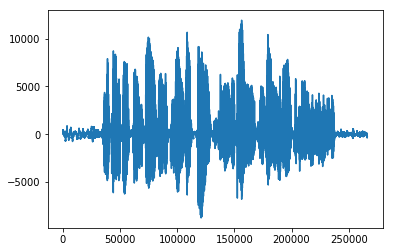

In [4]:
print('Sample text and its audio')
print(sentences[4])
plt.plot(total_audio[4])

In [5]:
# making the audio array of constant size so that it can be fed into the LSTM Layers
maxlen_audio = max([len(a) for a in total_audio])
maxlen_text = max([len(s) for s in sentences])
print('[%]Maximum length of sound:', maxlen_audio)
print('[%]Maximum length of text:', maxlen_text)

# Hyperparam
e_dim = 1000 # this is the size of embedding vector
maxlen_audio = int(maxlen_audio/1000 + 1) * 1000

[%]Maximum length of sound: 452661
[%]Maximum length of text: 36


In [6]:
# coverting the data to proper vectors
data_x = []
for a in total_audio:
    temp = []
    for x in a:
        temp.append(x)
    data_x.append(temp)
data_x = np.array(data_x)

In [15]:
# Making the audio of constant size
print('[!]Before Padding, shape of total_audio:', total_audio.shape)
data_x = pad_sequences(sequences = data_x, maxlen = maxlen_audio)
print('[*]Shape of data_x:', data_x.shape)

[!]Before Padding, shape of total_audio: (503,)
[*]Shape of data_x: (503, 453000)


In [20]:
data_y = np.zeros(shape = (len(data_x), len(tokens)))
for i,s in enumerate(sentences):
    for t in s:
        data_y[i][word2id[t]] = 1.0
print('[*]Shape of data_y:',data_y.shape)

[*]Shape of data_y: (503, 1441)


In [26]:
# need to convert the data_x to proper shape
input_data = []
for a in data_x:
    input_data.append(np.reshape(a, [-1, e_dim]))
input_data = np.array(input_data)
print('[*]Shape of input_data:', input_data.shape)

[*]Shape of input_data: (503, 453, 1000)


In [ ]:
# Now making the model
model = Sequential()
model.add(LSTM(units = 1000, input_shape = (453, e_dim)))
model.add(Dense(2000, activation = 'relu'))
model.add(Dense(len(tokens), activation = 'softmax'))
model.compile('Adam', loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(input_data, data_y, epochs = 16, batch_size = 64)

Epoch 1/16
